In [1]:
print("hello")

hello


In [3]:
import torch
print(torch.cuda.is_available())           # Should be True
print(torch.cuda.get_device_name(0))       # Should say: Quadro T2000


True
Quadro T2000 with Max-Q Design


Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



PSO Iterations: 100%|██████████| 10/10 [20:24<00:00, 122.47s/it]

Best Hyperparameters Found:
Learning Rate: 0.0036314235832378672
Hidden Size: 251
Batch Size: 77


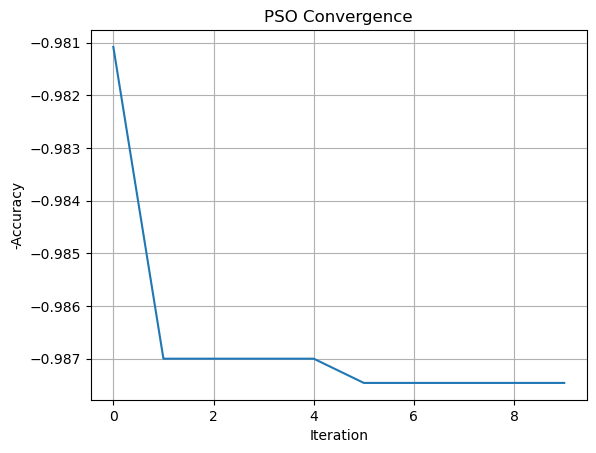

In [7]:
# PSO-based Hyperparameter Optimization for Simple Neural Network

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------
# Model Definition
# ----------------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ----------------------------
# Objective Function for PSO
# ----------------------------
def evaluate_model(hyperparams, train_loader, val_loader, device):
    lr, hidden_size, batch_size = hyperparams
    hidden_size = int(hidden_size)
    batch_size = int(batch_size)

    model = SimpleNN(784, hidden_size, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(3):  # Partial training for exploration phase
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    return -acc  # PSO minimizes this value

# ----------------------------
# Particle Swarm Optimization
# ----------------------------
class PSO:
    def __init__(self, num_particles, bounds, train_loader, val_loader, device):
        self.num_particles = num_particles
        self.bounds = bounds
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.dim = len(bounds)
        self.w = 0.5  # inertia
        self.c1 = 1   # personal weight
        self.c2 = 2   # social weight

        self.X = np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(num_particles, self.dim))
        self.V = np.zeros((num_particles, self.dim))
        self.pbest = self.X.copy()
        self.pbest_scores = np.array([float('inf')] * num_particles)
        self.gbest = None
        self.gbest_score = float('inf')
        self.history = []

    def optimize(self, iterations):
        for iter in tqdm(range(iterations), desc="PSO Iterations"):
            for i in range(self.num_particles):
                score = evaluate_model(self.X[i], self.train_loader, self.val_loader, self.device)
                if score < self.pbest_scores[i]:
                    self.pbest_scores[i] = score
                    self.pbest[i] = self.X[i]
                if score < self.gbest_score:
                    self.gbest_score = score
                    self.gbest = self.X[i]
            
            for i in range(self.num_particles):
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)
                self.V[i] = (self.w * self.V[i] +
                             self.c1 * r1 * (self.pbest[i] - self.X[i]) +
                             self.c2 * r2 * (self.gbest - self.X[i]))
                self.X[i] += self.V[i]
                # Clip values to bounds
                for d in range(self.dim):
                    self.X[i][d] = np.clip(self.X[i][d], self.bounds[d][0], self.bounds[d][1])

            self.history.append(self.gbest_score)

# ----------------------------
# Data Preparation
# ----------------------------
def load_data(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_set, val_set = random_split(dataset, [50000, 10000])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ----------------------------
# Run PSO Optimization
# ----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bounds = [(1e-4, 1e-2), (64, 256), (32, 256)]  # lr, hidden, batch_size
    temp_loader, _ = load_data(batch_size=64)

    pso = PSO(num_particles=5, bounds=bounds, train_loader=temp_loader,
              val_loader=temp_loader, device=device)
    pso.optimize(iterations=10)

    print("Best Hyperparameters Found:")
    print("Learning Rate:", pso.gbest[0])
    print("Hidden Size:", int(pso.gbest[1]))
    print("Batch Size:", int(pso.gbest[2]))

    plt.plot(pso.history)
    plt.title("PSO Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("-Accuracy")
    plt.grid()
    plt.show()


PSO Iterations: 100%|██████████| 10/10 [24:27<00:00, 146.79s/it]

Best Hyperparameters Found:
Learning Rate: 0.0020594627000086302
Hidden Size: 256
Batch Size: 256


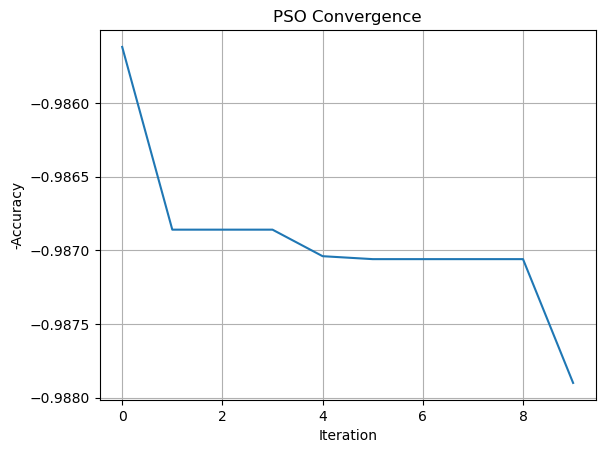



🚀 Retraining best configuration from PSO for 20,000 epochs (Baseline)

Epoch [500/20000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [1000/20000] - Loss: 0.0001, Accuracy: 100.00%
Epoch [1500/20000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [2000/20000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [2500/20000] - Loss: 0.0000, Accuracy: 100.00%


In [ ]:
# PSO-based Hyperparameter Optimization for Simple Neural Network (Baseline-Integrated)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# ----------------------------
# Model Definition
# ----------------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ----------------------------
# Objective Function for PSO (Exploration)
# ----------------------------
def evaluate_model(hyperparams, train_loader, val_loader, device):
    lr, hidden_size, batch_size = hyperparams
    hidden_size = int(hidden_size)
    batch_size = int(batch_size)

    model = SimpleNN(784, hidden_size, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(3):  # Short training (Exploration Phase)
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    return -acc

# ----------------------------
# PSO Algorithm
# ----------------------------
class PSO:
    def __init__(self, num_particles, bounds, train_loader, val_loader, device):
        self.num_particles = num_particles
        self.bounds = bounds
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.dim = len(bounds)
        self.w = 0.5
        self.c1 = 1
        self.c2 = 2

        self.X = np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(num_particles, self.dim))
        self.V = np.zeros((num_particles, self.dim))
        self.pbest = self.X.copy()
        self.pbest_scores = np.array([float('inf')] * num_particles)
        self.gbest = None
        self.gbest_score = float('inf')
        self.history = []

    def optimize(self, iterations):
        for iter in tqdm(range(iterations), desc="PSO Iterations"):
            for i in range(self.num_particles):
                score = evaluate_model(self.X[i], self.train_loader, self.val_loader, self.device)
                if score < self.pbest_scores[i]:
                    self.pbest_scores[i] = score
                    self.pbest[i] = self.X[i]
                if score < self.gbest_score:
                    self.gbest_score = score
                    self.gbest = self.X[i]
            
            for i in range(self.num_particles):
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)
                self.V[i] = (self.w * self.V[i] +
                             self.c1 * r1 * (self.pbest[i] - self.X[i]) +
                             self.c2 * r2 * (self.gbest - self.X[i]))
                self.X[i] += self.V[i]
                for d in range(self.dim):
                    self.X[i][d] = np.clip(self.X[i][d], self.bounds[d][0], self.bounds[d][1])
            self.history.append(self.gbest_score)

# ----------------------------
# Retrain Best Configuration (Exploitation Phase)
# ----------------------------
def retrain_best_model(hyperparams, train_loader, val_loader, device, total_epochs=20000):
    lr, hidden_size, batch_size = hyperparams
    hidden_size = int(hidden_size)
    batch_size = int(batch_size)
    model = SimpleNN(784, hidden_size, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    acc_history = []
    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(total_epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        train_loss_history.append(epoch_loss / len(train_loader))
        acc_history.append(accuracy)

        if (epoch+1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{total_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss_history": train_loss_history,
                "acc_history": acc_history
            }, f"checkpoints/pso_best_ep{epoch+1}.pth")

# ----------------------------
# Data Preparation
# ----------------------------
def load_data(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_set, val_set = random_split(dataset, [50000, 10000])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bounds = [(1e-4, 1e-2), (64, 256), (32, 256)]
    temp_loader, _ = load_data(batch_size=64)

    # PSO Exploration
    pso = PSO(num_particles=5, bounds=bounds, train_loader=temp_loader, val_loader=temp_loader, device=device)
    pso.optimize(iterations=10)
    print("Best Hyperparameters Found:")
    print("Learning Rate:", pso.gbest[0])
    print("Hidden Size:", int(pso.gbest[1]))
    print("Batch Size:", int(pso.gbest[2]))

    # Convergence Plot
    plt.plot(pso.history)
    plt.title("PSO Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("-Accuracy")
    plt.grid()
    plt.show()

    # Exploitation Phase
    print("\n\n🚀 Retraining best configuration from PSO for 20,000 epochs (Baseline)\n")
    best_params = pso.gbest
    batch_size = int(best_params[2])
    train_loader, val_loader = load_data(batch_size=batch_size)
    retrain_best_model(best_params, train_loader, val_loader, device, total_epochs=20000)


/tmp/ipykernel_45306/3155504003.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/pso_best_ep2500.pth")  # or latest checkpoint


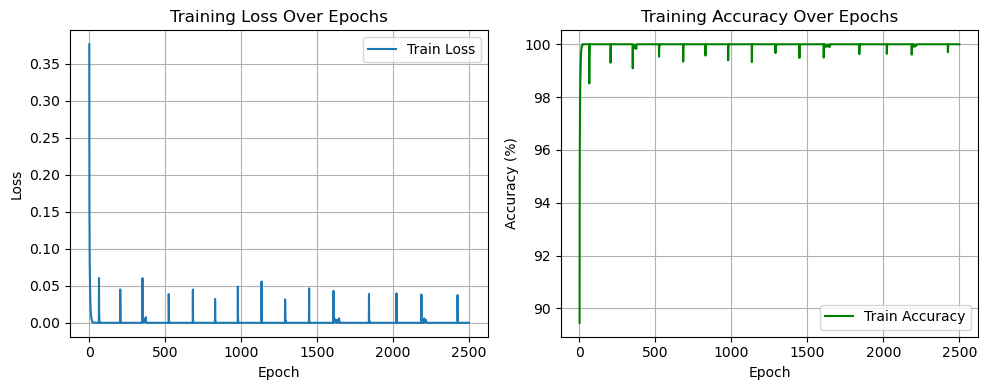

In [1]:
import torch
import matplotlib.pyplot as plt

# -----------------------
# Load checkpoint
# -----------------------
ckpt = torch.load("checkpoints/pso_best_ep2500.pth")  # or latest checkpoint

# Extract values
loss_history = ckpt["loss_history"]
acc_history = ckpt["acc_history"]
epochs = list(range(1, len(loss_history) + 1))

# -----------------------
# Plot Loss
# -----------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()

# -----------------------
# Plot Accuracy
# -----------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label="Train Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("pso_baseline_summary.png", dpi=300)
plt.show()


Random Search ========================

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Synthetic dataset (e.g., 20 features, 3 classes, 5000 samples)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5,
                           n_classes=3, random_state=0)
# Split into train and validation sets (e.g., 80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert to PyTorch tensors and create datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

# Hyperparameter search space
total_epochs = 5000  # total exploration budget in epochs
epochs_per_trial = 200  # train each sampled config for this many epochs
num_trials = total_epochs // epochs_per_trial  # number of random configurations to try

lr_min, lr_max = 1e-4, 1e-1             # learning rate range (log-uniform sampling)
batch_choices = [16, 32, 64, 128]       # possible batch sizes
hidden_min, hidden_max = 50, 200        # range for hidden layer size (integer)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate a model to check dimensions (not yet training)
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))
model = SimpleNet(input_dim, hidden_size=100, output_size=num_classes).to(device)
print(model)


SimpleNet(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


In [3]:
criterion = nn.CrossEntropyLoss()

def evaluate(model, data_loader, device):
    """Compute average loss and accuracy of the model on the given data loader."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_x.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == batch_y).sum().item()
            total_samples += batch_x.size(0)
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


In [4]:
from tqdm import tqdm

best_val_acc = 0.0
best_config = None
best_model_state = None

# List to track the best-so-far accuracy after each trial (for convergence plot)
best_acc_progress = []

for trial in range(1, num_trials + 1):
    # Randomly sample hyperparameters
    lr = 10 ** np.random.uniform(np.log10(lr_min), np.log10(lr_max))   # log-uniform sample in [lr_min, lr_max]
    batch_size = int(np.random.choice(batch_choices))
    hidden_size = int(np.random.randint(hidden_min, hidden_max + 1))
    config = {'lr': lr, 'batch_size': batch_size, 'hidden_size': hidden_size}
    
    # Data loaders for this trial
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model and optimizer for this trial
    model = SimpleNet(input_dim, hidden_size, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_acc_trial = 0.0  # best validation accuracy in this trial
    # Training loop for the current trial
    for epoch in tqdm(range(1, epochs_per_trial + 1), desc=f"Trial {trial}/{num_trials}", leave=False):
        model.train()
        # Mini-batch training
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        # Validate at end of epoch
        val_loss, val_acc = evaluate(model, val_loader, device)
        # Update best accuracy in this trial
        if val_acc > best_val_acc_trial:
            best_val_acc_trial = val_acc
        # (Optionally, one could implement early stopping here based on val_loss/val_acc)
    # End of training for this trial
    
    # Check if this is the best config so far across all trials
    is_new_best = False
    if best_val_acc_trial > best_val_acc:
        best_val_acc = best_val_acc_trial
        best_config = config
        best_model_state = model.state_dict()  # save best model weights
        # Save checkpoint to file
        torch.save(best_model_state, "best_model.pth")
        is_new_best = True
    
    # Logging the result of this trial
    print(f"Trial {trial}/{num_trials}: lr={lr:.6f}, batch_size={batch_size}, hidden_size={hidden_size} "
          f"-> Val Acc: {val_acc:.4f}, Best Val Acc in trial: {best_val_acc_trial:.4f}"
          + (" **[New Best]**" if is_new_best else ""))
    best_acc_progress.append(best_val_acc)  # record current best after this trial

# After all trials, output the best configuration found
print(f"\nBest validation accuracy: {best_val_acc:.4f} achieved with configuration: {best_config}")


Trial 1/25: lr=0.004430, batch_size=32, hidden_size=117 -> Val Acc: 0.9440, Best Val Acc in trial: 0.9560 **[New Best]**


Trial 2/25: lr=0.037483, batch_size=128, hidden_size=59 -> Val Acc: 0.9290, Best Val Acc in trial: 0.9320


Trial 3/25: lr=0.007425, batch_size=64, hidden_size=86 -> Val Acc: 0.9360, Best Val Acc in trial: 0.9440


Trial 4/25: lr=0.000781, batch_size=16, hidden_size=138 -> Val Acc: 0.9360, Best Val Acc in trial: 0.9420


Trial 5/25: lr=0.000658, batch_size=32, hidden_size=89 -> Val Acc: 0.9310, Best Val Acc in trial: 0.9410


Trial 6/25: lr=0.003861, batch_size=16, hidden_size=131 -> Val Acc: 0.9190, Best Val Acc in trial: 0.9450


Trial 7/25: lr=0.059812, batch_size=32, hidden_size=122 -> Val Acc: 0.8530, Best Val Acc in trial: 0.8890


Trial 8/25: lr=0.000183, batch_size=128, hidden_size=129 -> Val Acc: 0.9370, Best Val Acc in trial: 0.9370


Trial 9/25: lr=0.040741, batch_size=64, hidden_size=149 -> Val Acc: 0.9140, Best Val Acc in trial: 0.9210


Trial 10/25: lr=0.024973, batch_size=128, hidden_size=79 -> Val Acc: 0.9430, Best Val Acc in trial: 0.9480


Trial 11/25: lr=0.021958, batch_size=64, hidden_size=82 -> Val Acc: 0.9280, Best Val Acc in trial: 0.9460


Trial 12/25: lr=0.005573, batch_size=32, hidden_size=177 -> Val Acc: 0.9470, Best Val Acc in trial: 0.9540


Trial 13/25: lr=0.018873, batch_size=64, hidden_size=164 -> Val Acc: 0.9350, Best Val Acc in trial: 0.9440


Trial 14/25: lr=0.002336, batch_size=64, hidden_size=178 -> Val Acc: 0.9440, Best Val Acc in trial: 0.9490


Trial 15/25: lr=0.000114, batch_size=32, hidden_size=183 -> Val Acc: 0.9390, Best Val Acc in trial: 0.9410


Trial 16/25: lr=0.006859, batch_size=16, hidden_size=67 -> Val Acc: 0.9260, Best Val Acc in trial: 0.9370


Trial 17/25: lr=0.067802, batch_size=32, hidden_size=92 -> Val Acc: 0.8070, Best Val Acc in trial: 0.8640


Trial 18/25: lr=0.001198, batch_size=16, hidden_size=51 -> Val Acc: 0.9200, Best Val Acc in trial: 0.9400


Trial 19/25: lr=0.012385, batch_size=32, hidden_size=107 -> Val Acc: 0.9310, Best Val Acc in trial: 0.9430


Trial 20/25: lr=0.010007, batch_size=128, hidden_size=61 -> Val Acc: 0.9320, Best Val Acc in trial: 0.9440


Trial 21/25: lr=0.000428, batch_size=128, hidden_size=178 -> Val Acc: 0.9430, Best Val Acc in trial: 0.9440


Trial 22/25: lr=0.000884, batch_size=32, hidden_size=190 -> Val Acc: 0.9450, Best Val Acc in trial: 0.9530


Trial 23/25: lr=0.005136, batch_size=16, hidden_size=118 -> Val Acc: 0.9420, Best Val Acc in trial: 0.9460


Trial 24/25: lr=0.075309, batch_size=128, hidden_size=177 -> Val Acc: 0.8760, Best Val Acc in trial: 0.9150


Trial 25/25: lr=0.008039, batch_size=16, hidden_size=150 -> Val Acc: 0.9340, Best Val Acc in trial: 0.9420

Best validation accuracy: 0.9560 achieved with configuration: {'lr': 0.004430375245218264, 'batch_size': 32, 'hidden_size': 117}


retraining script for this best config (15,000 epochs)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# Load your dataset
# (Assuming you already have X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor ready)
# Replace below with your dataset if needed
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_classes=3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

# Best config from Random Search
lr = 0.004430375245218264
hidden_size = 117
batch_size = 32
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

model = SimpleNet(input_dim, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_loss_history = []
acc_history = []

os.makedirs("checkpoints_random", exist_ok=True)

print(f"🚀 Starting retraining with best config from Random Search for 15,000 epochs")
for epoch in range(15000):
    model.train()
    epoch_loss, correct, total = 0.0, 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    acc = 100 * correct / total
    train_loss_history.append(epoch_loss / len(train_loader))
    acc_history.append(acc)

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/15000] - Loss: {epoch_loss:.4f}, Accuracy: {acc:.2f}%")
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss_history": train_loss_history,
            "acc_history": acc_history
        }, f"checkpoints_random/random_best_ep{epoch+1}.pth")

# Optional: Save final model
torch.save(model.state_dict(), "checkpoints_random/random_final_model.pth")


🚀 Starting retraining with best config from Random Search for 15,000 epochs
Epoch [500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [1000/15000] - Loss: 0.0002, Accuracy: 100.00%
Epoch [1500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [2000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [2500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [3000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [3500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [4000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [4500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [5000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [5500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [6000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [6500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [7000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [7500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [8000/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [8500/15000] - Loss: 0.0000, Accuracy: 100.00%
Epoch [9000/15000] - Los

/tmp/ipykernel_9019/2026681933.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints_random/random_best_ep15000.pth")  # Adjust filename if diff

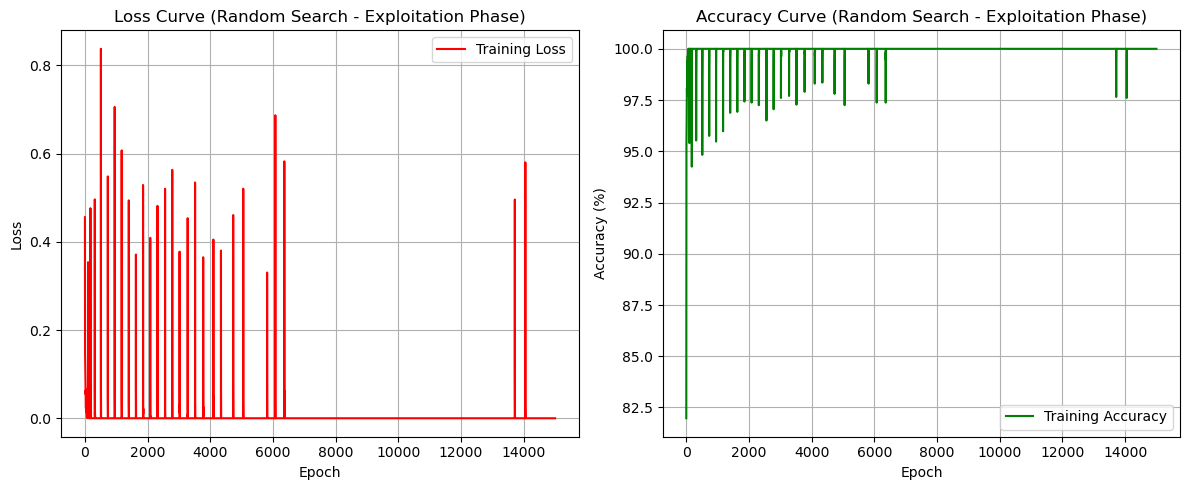

In [6]:
import torch
import matplotlib.pyplot as plt

# Load your checkpoint
ckpt = torch.load("checkpoints_random/random_best_ep15000.pth")  # Adjust filename if different

loss_history = ckpt["loss_history"]
acc_history = ckpt["acc_history"]
epochs = list(range(1, len(loss_history) + 1))

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, label="Training Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Random Search - Exploitation Phase)")
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label="Training Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve (Random Search - Exploitation Phase)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("random_baseline_convergence.png", dpi=300)
plt.show()


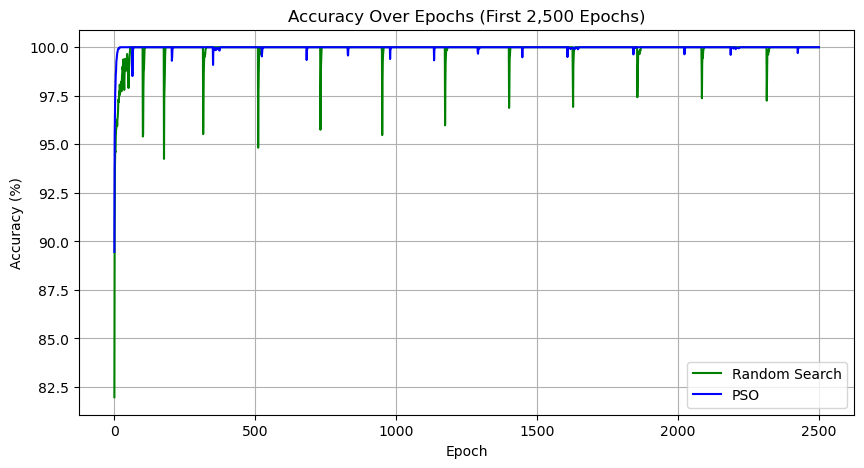

In [13]:
epochs = list(range(1, 2501))
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc_random[:2500], label="Random Search", color="green")
plt.plot(epochs, acc_pso, label="PSO", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs (First 2,500 Epochs)")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_comparison_2500.png", dpi=300)
plt.show()


/tmp/ipykernel_9019/3487489454.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_pso = torch.load("checkpoints/pso_best_ep2500.pth")


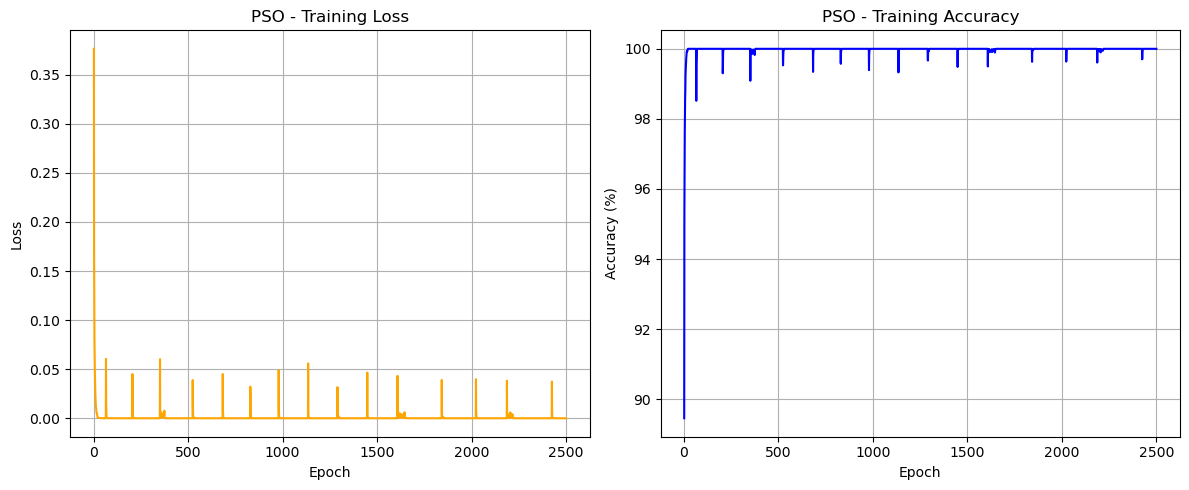

In [15]:
# Load PSO Checkpoint
ckpt_pso = torch.load("checkpoints/pso_best_ep2500.pth")
loss_pso = ckpt_pso["loss_history"]
acc_pso = ckpt_pso["acc_history"]
epochs_pso = list(range(1, len(loss_pso) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_pso, loss_pso, label="PSO Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PSO - Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_pso, acc_pso, label="PSO Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("PSO - Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.savefig("pso_2500_full.png", dpi=300)
plt.show()


/tmp/ipykernel_9019/1648821690.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_random = torch.load("checkpoints_random/random_best_ep15000.pth")


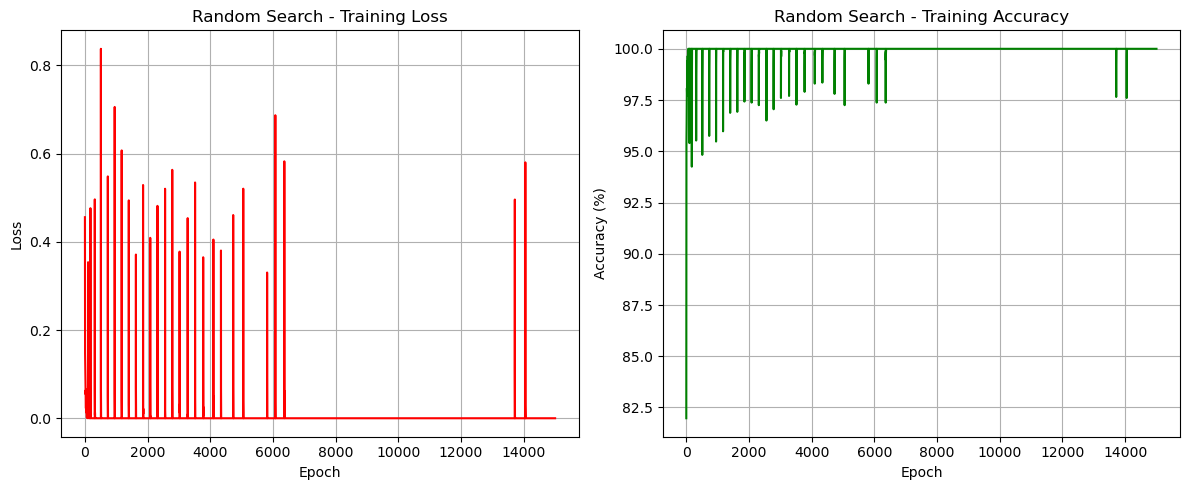

In [16]:
# Load Random Search Checkpoint
ckpt_random = torch.load("checkpoints_random/random_best_ep15000.pth")
loss_random = ckpt_random["loss_history"]
acc_random = ckpt_random["acc_history"]
epochs_random = list(range(1, len(loss_random) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_random, loss_random, label="Random Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Random Search - Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_random, acc_random, label="Random Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Random Search - Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.savefig("random_search_15000_full.png", dpi=300)
plt.show()
